In [1]:
!pip install tensorflow-gpu
# !pip install tensorflow_text # I could use BERT (?)

^C


In [ ]:
import logging
from psutil import virtual_memory

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
ram_gb = virtual_memory().total / 1e9

tf_response = {
    'error': None,
    'TF version': '',
    'COLAB': None,
    'GPU': False,
    'ram_gb': ''
}

try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    tf_response['COLAB'] = COLAB
except OSError as error:
    COLAB = False
    response['error'] = logging.debug('You are not using your specify version of TensorFlow')
    tf_response['COLAB'] = COLAB
finally:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

    from sklearn.model_selection import train_test_split
    
    if tf.config.list_physical_devices('GPU'):
        GPU = True
        tf_response['GPU'] = GPU
    tf_response['TF_version'] = tf.__version__
    
    if tf_response['COLAB'] == True:
        if gpu_info.find('failed') >= 0:
            print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator')
            print('Re-execute this cell.')
        else:
            print(gpu_info)
        
        if ram_gb < 20:
            print('To enable a high-RAM runtime, select the Runtime > "Change runtime type menu"')
            print('Select high-RAM in the runtime shape dropdown')
            print('Re-execute this cell')
            tf_response['ram_gb'] = 'low-RAM runtime'
        else:
            tf_response['ram_gb'] = 'high-RAM runtime'
        print('\nRuntime {:.2f} GB of available RAM\n'.format(ram_gb))
    print(tf_response)

Sat Aug 22 17:12:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import sys
import re


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from PIL import Image # Pillow with WordCloud to image manipulation

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Stanza NLP
!pip install stanza
import stanza

stanza.download('en', package='ewt', processors='tokenize,mwt,pos,lemma', verbose=True)
stNLP = stanza.Pipeline(processors='tokenize,mwt,pos,lemma',
                      lang='en',
                      use_gpu=True)

2020-08-22 17:12:42 WARNING: Can not find mwt: ewt from official model list. Ignoring it.
2020-08-22 17:12:42 INFO: Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| pretrain  | ewt     |

2020-08-22 17:12:42 INFO: File exists: /root/stanza_resources/en/tokenize/ewt.pt.
2020-08-22 17:12:43 INFO: File exists: /root/stanza_resources/en/pos/ewt.pt.
2020-08-22 17:12:43 INFO: File exists: /root/stanza_resources/en/lemma/ewt.pt.
2020-08-22 17:12:48 INFO: File exists: /root/stanza_resources/en/pretrain/ewt.pt.
2020-08-22 17:12:48 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-08-22 17:12:48 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-08-22 17:12:48 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt  

In [ ]:
doc = stNLP('Barack Obama was born in Hawai.')

print('\n')
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')



word: Barack 	lemma: Barack
word: Obama 	lemma: Obama
word: was 	lemma: be
word: born 	lemma: bear
word: in 	lemma: in
word: Hawai 	lemma: Hawai
word: . 	lemma: .


In [ ]:
!pip install spacy
!spacy download en_core_web_lg # sm md lg
import spacy
spNLP = spacy.load('en_core_web_lg')
spNLP.max_length = 103950039 # or higher
# spacy.prefer_gpu() #will not work with stanza

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
vocab_size = 5000
embedding_dim = 64
max_lenght = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

PATH_FILE = 'data/training.1600000.processed.noemoticon.csv'

In [ ]:
def load_data(data_path=None):
    !mkdir -p data
    !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P data
    !unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip
    
    # return x, y

In [ ]:
# lemmatizion
# stanza
def stanza_lemma(text):
    doc = stNLP(text)
    return ' '.join([word.lemma for sent in doc.sentences for word in sent.words])

# nltk
!pip install nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def nltk_lemma(text):
    lemmatizer = WordNetLemmatizer()
    lemmatizer.lemmatize(text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def preprocess_dataset():
    # load_data
    load_data()
    print('database loaded\n')

    # cleaning data
    unclean_df = pd.read_csv(PATH_FILE,
                     names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                     encoding='latin-1') # if utf-8: UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 232719-232720: invalid continuation byte

    unclean_df.polarity = unclean_df.polarity.replace({0: 0, 4: 1}) # replace polarity
    unclean_df = unclean_df.drop(columns=['id', 'date', 'query', 'user']) # dropping unneeded columns

    # sample
    #df_sample = unclean_df.sample(n=500000)
    #df_sample.polarity.value_counts()

    # lower case
    unclean_df['text'] = unclean_df['text'].str.lower()

    # remove character and numbers
    unclean_df['text'] = unclean_df['text'].apply(lambda x: re.sub(r'https://www\.|http:\.|https://|www\.', '', x))
    unclean_df['text'] = unclean_df['text'].apply(lambda x: re.sub(r'[\S]+\.(net|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil|cl)[\S]*\s?', '', x))
    unclean_df['text'] = unclean_df['text'].apply(lambda x: re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-zÁ-Úá-ú \t])|(\w+:\/\/\S+)|^rt|http.+?%', '', x))
    unclean_df['text'] = unclean_df['text'].apply(lambda x: re.sub(r'\d+', '', x))


    # rewritting the created file without NaN values
    unclean_df.to_csv('data/sentiment140-subset.csv', 
              quotechar='"', # check later!
              encoding='latin-1',
              index=False)

    # clean csv
    df = pd.read_csv('data/sentiment140-subset.csv', encoding='latin-1').dropna()

    # checking if there's any NaN values
    isnull = [i for i in (df['text'].isnull()) if i == True]
    if isnull != []:
        sys.exit(0) # add response object here

    
    # STOPWORDS
    # Getting in a list all the stopwords of the dataframe 
    '''
    spacy_stop_words = list(dict.fromkeys([str(i) for i in spNLP(' '.join(j for j in df['text'])) if i.is_stop == True]))

    stop_words = stopwords.words('english')
    stop_words.extend(spacy_stop_words)
    stop_words = set(stop_words)
    
    df['text'] = df['text'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop_words]))
    
    # Lemmatization Stanza vs NLTK
    df['text'] = df['text'].apply(lambda x: stanza_lemma(x))
    df['text'] = df['text'].apply(lambda x: nltk_lemma(x))

    # check new stopwords here!
    df['text'] = df['text'].apply(lambda x: ' '.join(
        [i for i in x.split() if i not in stop_words]
    ))
    '''
    # return df
    x, y = df.text, df.polarity
    return x, y

In [ ]:
# test peprocess_dataset
x, y = preprocess_dataset()

File ‘data/training.1600000.processed.noemoticon.csv.zip’ already there; not retrieving.

Archive:  data/training.1600000.processed.noemoticon.csv.zip
database loaded



0    799982
1    799969
Name: polarity, dtype: int64


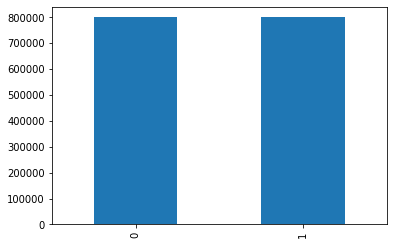

In [ ]:
# test peprocess_dataset
print(y.value_counts())
y.value_counts().plot(kind='bar')
plt.show()

In [ ]:
# test peprocess_dataset
print(Counter(x).most_common(10))

[(' ', 2301), (' thanks ', 1572), (' get  followers a day using once you add everyone you are on the train or pay vip ', 1324), (' thank you ', 998), (' i am lost please help me find a good home ', 507), (' me too ', 453), ('good morning ', 444), (' good morning ', 355), (' i know ', 342), ('  ', 310)]


In [ ]:
def prepare_dataset(test_size=0.2, validation_size=0.2):
    # split dataset (as string into panda.core.series.Serie object)
    (x, y) = preprocess_dataset()

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

    # testing
    print(len(x_train), len(y_train))     
    #print(len(x_validation, y_validation)
    print(len(x_test), len(y_test))

    # return (x_train, y_train), (x_validation, y_validation), (x_test, y_test)

In [ ]:
# test prepare_dataset
prepare_dataset()

File ‘data/training.1600000.processed.noemoticon.csv.zip’ already there; not retrieving.

Archive:  data/training.1600000.processed.noemoticon.csv.zip
database loaded

1279960 1279960
319991 319991


In [ ]:
def build_model(input_shape, learning_rate=0.0001, opt='adam', loss='categorical_crossentropy'):
    model = tf.keras.layers.Sequential()

    # layers
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(embedding_dim)))

    # softmax output layer
    model.add(tf.keras.layers.Dense(units=10, 
                                    activation='softmax'))

    # optimizer & loss
    opt = tf.optimizers.Adam(learning_rate=learning_rate)
    loss='sparse_categorical_crossentropy'

    # compile model
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
def train(model, x_train, y_train, x_validation, y_validation, epochs, batch_size=32, patience=5, verbose=1, monitor='accuracy'):
    # callback
    early_callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, # also try 'val_loss'
                                                      verbose=1, mode='auto', restore_best_weights=True,
                                                      min_delta=1e-3, patience=patience)

    # train model
    history = model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs, verbose=verbose
                        validation_data=(x_validation, y_validation), # x_test, y_test
                        callbacks=[early_callback])
    return history

In [ ]:
def plot_history_(history):
    fitModel_dict = history.history
    acc = fitModel_dict['accuracy']
    val_acc = fitModel_dict['val_accuracy']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(15, 8))
    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower right')
    plt.ylim((0.5, 1))

    plt.show()

def plot_history(history, string):
    fitModel_dict = history.history
    plt.plot(fitModel_dict[string])
    plt.plot/fitModel_dict['val_' + string]
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

# test
plot_history(history, 'accuracy')
plot_history(history, 'loss')

In [ ]:
def main():
    x_train, y_train, x_validation, y_validation, x_test, y_test = prepare_dataset(data_path) # define data path for google colab and visual studio with statements

    # input_shape
    # model = build_model()

    # history = train(model)
    # plot_history(history)

    # test_loss, test_accuracy = model.evaluate(x_test, y_test)
    # print('\nTest:\nLoss: {}\nAccuracy: {}').format(loss, accuracy * 100)

    # model.save(model.h5)

In [ ]:
if __name__ == "__main__":
    main()